In [1]:
import os
from src.dataPipeline import DataPipeline

os.chdir('..')

dp = DataPipeline()
df = dp.runPipeline(normalizeAndStandardize=True)

C:\FHNW_Programmiersachen\5_Sem\immo_challenge\src\dataPipeline.py:39: DtypeWarning: Columns (3,4,5,6,11,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,45,46,47,49,50,107,110,114,115,116,119,120,121,124,125,126,128,131,132) have mixed types. Specify dtype option on import or set low_memory=False.
  self.data = pd.read_csv(filePath)
C:\FHNW_Programmiersachen\5_Sem\immo_challenge\src\dataPipeline.py:62: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ]].bfill(axis=1)['Space extracted']
C:\FHNW_Programmiersachen\5_Sem\immo_challenge\src\dataPipeline.py:67: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To o

In [2]:
from sklearn.model_selection import KFold
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error

y = df['price_cleaned']
y = np.log(y)
X = df.drop(columns=['price_cleaned'])

# Set up K-Fold Cross-Validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)
mapes = []
models = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    model = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    y_pred = np.exp(y_pred)
    y_test = np.exp(y_test)   
    
    mape = mean_absolute_percentage_error(y_test, y_pred)*100
    mapes.append(mape)
    models.append(model)

# Durchschnittlicher MAPE
average_mape = np.mean(mapes)
print(f'Durchschnittlicher MAPE über K-Folds: {average_mape:.2f}%')


Durchschnittlicher MAPE über K-Folds: 0.68%


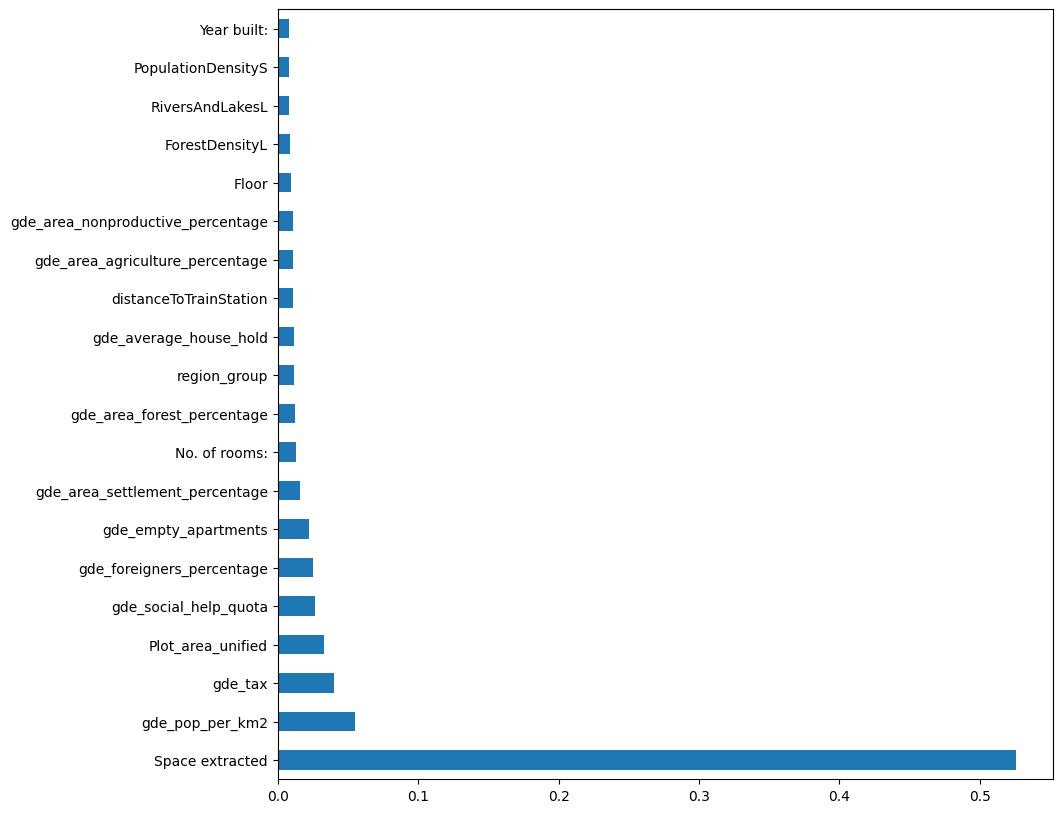

In [3]:
# Mean feature importance
import matplotlib.pyplot as plt
import pandas as pd

feature_importances = np.mean([model.feature_importances_ for model in models], axis=0)
feature_importances = pd.Series(feature_importances, index=X.columns)
feature_importances.sort_values(ascending=False, inplace=True)

plt.figure(figsize=(10, 10))
feature_importances[:20].plot(kind='barh')
plt.show()

In [4]:
from sklearn.model_selection import KFold
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error

y = df['price_cleaned']
y = np.log(y)

X = df.drop(columns=['price_cleaned'])

# Set up K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
mapes = []
models = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    model = RandomForestRegressor(n_estimators=250, random_state=42, n_jobs=-1)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    y_pred = np.exp(y_pred)
    y_test = np.exp(y_test)
    
    mape = mean_absolute_percentage_error(y_test, y_pred)*100
    mapes.append(mape)
    models.append(model)

# Durchschnittlicher MAPE
average_mape = np.mean(mapes)
print(f'Durchschnittlicher MAPE über K-Folds: {average_mape:.2f}%')

Durchschnittlicher MAPE über K-Folds: 0.69%


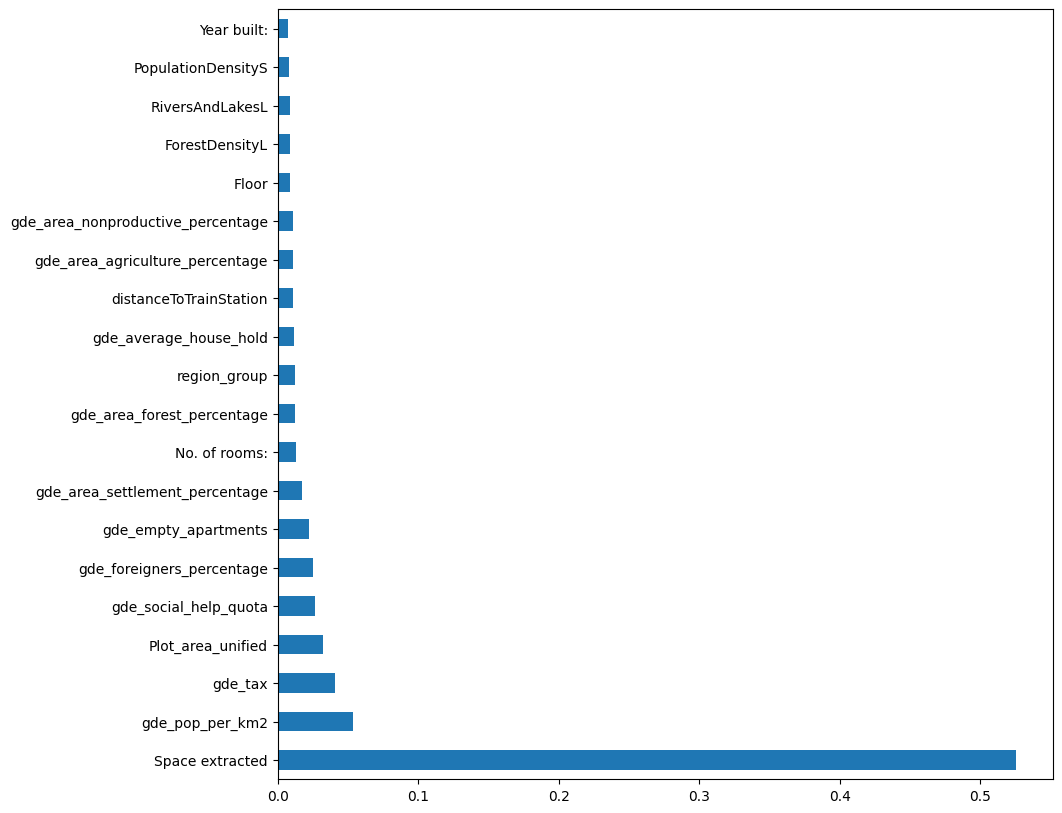

In [5]:
feature_importances = np.mean([model.feature_importances_ for model in models], axis=0)
feature_importances = pd.Series(feature_importances, index=X.columns)
feature_importances.sort_values(ascending=False, inplace=True)

plt.figure(figsize=(10, 10))
feature_importances[:20].plot(kind='barh')
plt.show()